<a href="https://colab.research.google.com/github/rmorlowski/Artificial-Intelligence-Deep-Learning/blob/master/MNIST_MLP_Visualizing_Weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST Neural Networks

This individual assignment involves fitting a neural network to the MNIST data, testing alternative network structures, activation functions, optimization methods, and/or hyperparameter settings. For these models, classification performance, accuracy and processing time will be compared across experiments.

**The Benchmark Experiment: ** This assignment concerns a single hidden layer. See what happens when you change the number of nodes in that single hidden layer, going from few to many nodes. Note that having a single layer with a single node is similar to employing what is known as a multinomial logit model (logistic regression if there are only two classes).  Due to the time required to fit each neural network, we will observe only one trial for each cell in the design. Also, we will be using a simple training-and-test split with the split having been performed previously. That is, we use the training and test sets that come with MNIST.

Relevant documentation includes:

*   [A.Géron, handson-ml](https://github.com/ageron/handson-ml/blob/master/11_deep_learning.ipynb)
*   [Brownlee - Handwritten Digit Recognition using Convolutional Neural Networks in Python with Keras](https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/)
*   [F.Chollet - Deep Learning with Python](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.6-classifying-newswires.ipynb)
*   [sklearn.neural_network.MLPClassifier (sci-kit learn)](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)
*   [Visualization of MLP weights on MNIST (sci-kit learn)](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html)
*   [Visualizing Weights and Convolutions (Keras)](https://github.com/keras-team/keras/issues/431)


An example experiment could include ten for the number of nodes per inner layer and two values for the number of inner layers total (with one single hidden layer). Various machine learning hyperparameter settings may be used.


---


### Section 1: Ingest - Data Survey

For this assignment we will develop a neural network classifier that may be used to predict which of the ten digits is being written.

Check for GPU

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Import packages

In [0]:
import time
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
from keras.datasets import mnist
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
import pandas as pd
import statsmodels.formula.api as smf  # R-like model specification
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, make_scorer 
from sklearn.model_selection import cross_val_score, train_test_split

In [0]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

**MNIST Dataset**

Gather data for the MNIST dataset.  These data consist of 70 thousand observations. Utilize the first 60 thousand as a model development set and the final 10 thousand as a holdout test set.

Load Train/Test split of the dataset in preparation for modeling.  Split the MNIST dataset into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).

In [0]:
#split train & test data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


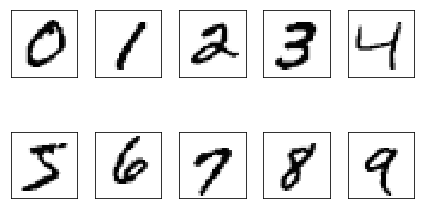

In [0]:
# plot sample training images
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_all.png', dpi=300)
plt.show()

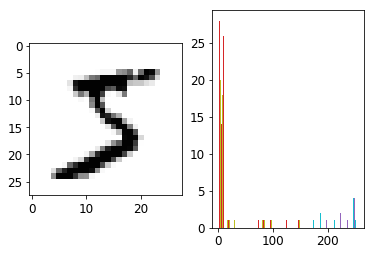

In [0]:
# Let's plot an image and histogram to quickly visualize the pixel data.
%matplotlib inline

# We'll show the image and its pixel value histogram side-by-side.
_, (ax1, ax2) = plt.subplots(1, 2)

# To interpret the values as a 28x28 image, we need to reshape
# the numpy array, which is one dimensional.
ax1.imshow(X_train[0].reshape(28, 28), cmap=plt.cm.Greys);

ax2.hist(X_train[0], bins=20, range=[0,255]);

The large number of 0 values correspond to the background of the image, another large mass of value 255 is black, and a mix of grayscale transition values in between. Both the image and histogram look sensible. But, it's good practice when training image models to normalize values to be centered around 0.

We'll do that next. The normalization code is fairly short, and it may be tempting to assume we haven't made mistakes, but we'll double-check by looking at the rendered input and histogram again. Malformed inputs are a surprisingly common source of errors when developing new models.

#### Scale Data

In [0]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

In [0]:
# scale the data for use in the neural network
X_train = X_train / 255
X_test = X_test / 255

In [0]:
#test split 'train'
X_train.shape

(60000, 784)

In [0]:
#test split 'test'
X_test.shape

(10000, 784)

### Section 2: EDA

#### Visualize MNIST

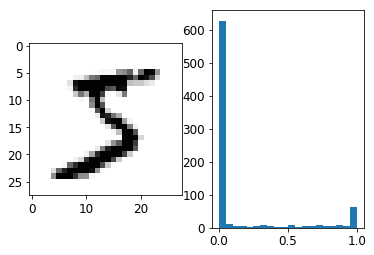

In [0]:
# We again plot the image and histogram to check that we 
# haven't mangled the data.
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(28, 28), cmap=plt.cm.Greys);
ax2.hist(X_train[0], bins=20, range=[0, 1]);

We've retained the correct image data while properly rescaling to the range [0, 1.0].

Training data shape (60000, 784)


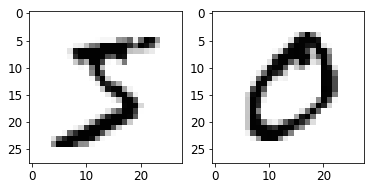

In [0]:
#check data in training set as visual:
print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(28, 28), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(28, 28), cmap=plt.cm.Greys);

In [0]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [0]:
# check data type
X_train.dtype

dtype('float32')

### Section 3: Modeling - Neural Networks

In summary, this section fits a number of neural networks, comparing processing time and performance across experimental treatments.

To make the example run faster, we use very few hidden units, and train only for a very short time. Training longer would result in weights with a much smoother spatial appearance.

#### MLP Classifier - 10 Neurons per layer

Model 1 - 1 layer with 10 nodes per layer, 10 epochs

In [0]:
mlp = MLPClassifier(hidden_layer_sizes = (10,), max_iter = 10, alpha = 1e-4,
                    solver = 'sgd', verbose = 10, tol = 1e-4, random_state = 1,
                    learning_rate_init=.1)

In [0]:
#Model 1 - 1D with 10 Neurons per hidden layer
%%time
mlp.fit(X_train, y_train)
print("Training set score:%f" %mlp.score(X_train, y_train))
print("Test set score:%f" %mlp.score(X_test, y_test))

Iteration 1, loss = 1.10231222
Iteration 2, loss = 0.83910444
Iteration 3, loss = 0.81156035
Iteration 4, loss = 0.78552812
Iteration 5, loss = 0.77373954
Iteration 6, loss = 0.76237467
Iteration 7, loss = 0.75660130
Iteration 8, loss = 0.75208621
Iteration 9, loss = 0.74717581
Iteration 10, loss = 0.74220701


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training set score:0.815417
Test set score:0.817700
CPU times: user 10.5 s, sys: 4.53 s, total: 15 s
Wall time: 7.9 s


The goal is to understand how the neurons/nodes in a simple single-hidden layer network have learned to represent features within the input data.

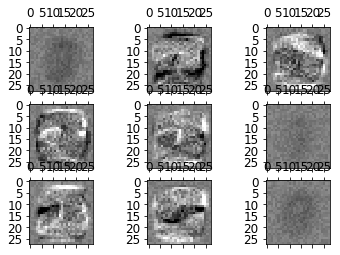

In [0]:
# plot MLP weights
fig, axes = plt.subplots(3, 3)
# use global min/max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
  ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 *vmin, vmax = .5* vmax)
  #ax.set_x_ticks(())
  #ax.set_y_ticks(())
  
plt.show()

Create a confusion matrix to assess accuracy.

In [0]:
# Predicting the Test set results
y_pred = mlp.predict(X_test)
y_pred = (y_pred > 0.5)

In [0]:
# Creating the Confusion Matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

[[ 969    0    0    2    4    0    1    1    1    2]
 [  22 1109    2    1    0    0    1    0    0    0]
 [ 108    9  877    6    8    1    9    5    7    2]
 [  83    6   37  853    2   15    0    7    4    3]
 [  48    6    5    0  891    0    4    1    0   27]
 [ 176    3    3   74   18  589   11    3   14    1]
 [  84    2    7    0   21    9  834    0    0    1]
 [ 122   12   21    2   12    0    0  846    0   13]
 [ 278   27    5   19   12   21   15    1  595    1]
 [ 107   11    1    6   39    0    0   10    5  830]]


#### MLP Classifier - 50 Neurons per layer

Model 2 - 1 layer with 50 nodes per layer, 10 epochs

In [0]:
mlp = MLPClassifier(hidden_layer_sizes = (50,), max_iter = 10, alpha = 1e-4,
                    solver = 'sgd', verbose = 10, tol = 1e-4, random_state = 1,
                    learning_rate_init=.1)

In [0]:
#Model 2 - 1D with 50 Neurons per hidden layer
%%time
mlp.fit(X_train, y_train)
print("Training set score:%f" %mlp.score(X_train, y_train))
print("Test set score:%f" %mlp.score(X_test, y_test))

Iteration 1, loss = 0.68406271
Iteration 2, loss = 0.37303567
Iteration 3, loss = 0.31256934
Iteration 4, loss = 0.27838449
Iteration 5, loss = 0.25614642
Iteration 6, loss = 0.24135793
Iteration 7, loss = 0.22529110
Iteration 8, loss = 0.21521206
Iteration 9, loss = 0.20508928
Iteration 10, loss = 0.19783897


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training set score:0.951433
Test set score:0.937300
CPU times: user 18.1 s, sys: 6.42 s, total: 24.5 s
Wall time: 12.7 s


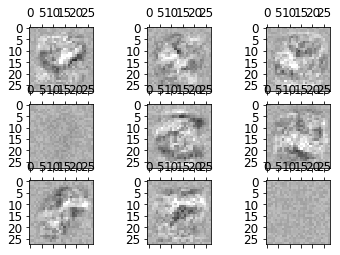

In [0]:
# plot MLP weights
fig, axes = plt.subplots(3, 3)
# use global min/max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
  ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 *vmin, vmax = .5* vmax)
  #ax.set_x_ticks(())
  #ax.set_y_ticks(())
  
plt.show()

Create a confusion matrix to assess accuracy.

In [0]:
# Predicting the Test set results
y_pred = mlp.predict(X_test)
y_pred = (y_pred > 0.5)

In [0]:
# Creating the Confusion Matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

[[ 971    0    0    1    0    2    3    1    2    0]
 [   8 1115    3    1    1    1    3    0    3    0]
 [  42    0  979    0    2    0    2    3    4    0]
 [  62    0    3  931    0    7    0    2    5    0]
 [  24    0    7    1  933    0    3    2    0   12]
 [  33    0    0    5    1  843    7    1    2    0]
 [  17    3    3    0    7    9  918    0    1    0]
 [  38    1   13   13    2    1    0  955    0    5]
 [  33    2    2    7    4    9    7    6  903    1]
 [  30    3    0    6   13    9    0    6    5  937]]


#### MLP Classifier - 100 Neurons per layer

Model 3 - 1 layer with 100 nodes per layer, 10 epochs

In [0]:
mlp = MLPClassifier(hidden_layer_sizes = (100,), max_iter = 10, alpha = 1e-4,
                    solver = 'sgd', verbose = 10, tol = 1e-4, random_state = 1,
                    learning_rate_init=.1)

In [0]:
#Model 3 - 1D with 100 Neurons per hidden layer
%%time
mlp.fit(X_train, y_train)
print("Training set score:%f" %mlp.score(X_train, y_train))
print("Test set score:%f" %mlp.score(X_test, y_test))

Iteration 1, loss = 0.57392601
Iteration 2, loss = 0.26492191
Iteration 3, loss = 0.20341701
Iteration 4, loss = 0.17182655
Iteration 5, loss = 0.14922503
Iteration 6, loss = 0.13269142
Iteration 7, loss = 0.11979009
Iteration 8, loss = 0.10912481
Iteration 9, loss = 0.09910097
Iteration 10, loss = 0.09110073


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training set score:0.977500
Test set score:0.951800
CPU times: user 25.2 s, sys: 7.97 s, total: 33.1 s
Wall time: 17 s


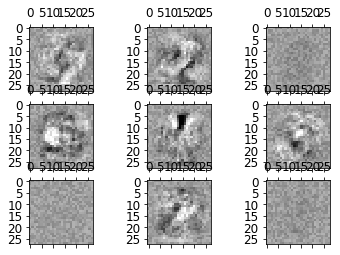

In [0]:
# plot MLP weights
fig, axes = plt.subplots(3, 3)
# use global min/max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
  ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 *vmin, vmax = .5* vmax)
  #ax.set_x_ticks(())
  #ax.set_y_ticks(())
  
plt.show()

Create a confusion matrix to assess accuracy.

In [0]:
# Predicting the Test set results
y_pred = mlp.predict(X_test)
y_pred = (y_pred > 0.5)

In [0]:
# Creating the Confusion Matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

[[ 973    0    0    1    1    0    1    2    0    2]
 [   9 1121    0    1    0    1    1    1    1    0]
 [  33    0  988    0    0    0    2    3    6    0]
 [  19    0    4  981    0    0    0    1    2    3]
 [  21    0    7    0  938    0    2    1    1   12]
 [  49    1    2   12    1  820    1    0    5    1]
 [  15    3    1    0    3    8  927    0    1    0]
 [  39    1    6    7    0    0    1  969    1    4]
 [  35    0    1    4    1    5    5    4  919    0]
 [  27    3    0    3    4    1    1    3    4  963]]


#### Keras DNN Model - 784 Neurons per Layer

The model is a simple neural network with one hidden layer with the same number of neurons as there are inputs (784).

In [0]:
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [0]:
# build the model, measure model performance
%%time
model = baseline_model()

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 2s - loss: 0.2761 - acc: 0.9213 - val_loss: 0.1414 - val_acc: 0.9581
Epoch 2/10
 - 1s - loss: 0.1091 - acc: 0.9687 - val_loss: 0.0933 - val_acc: 0.9712
Epoch 3/10
 - 1s - loss: 0.0714 - acc: 0.9789 - val_loss: 0.0783 - val_acc: 0.9766
Epoch 4/10
 - 1s - loss: 0.0494 - acc: 0.9858 - val_loss: 0.0682 - val_acc: 0.9799
Epoch 5/10
 - 1s - loss: 0.0357 - acc: 0.9899 - val_loss: 0.0648 - val_acc: 0.9799
Epoch 6/10
 - 1s - loss: 0.0262 - acc: 0.9928 - val_loss: 0.0601 - val_acc: 0.9814
Epoch 7/10
 - 1s - loss: 0.0192 - acc: 0.9954 - val_loss: 0.0629 - val_acc: 0.9809
Epoch 8/10
 - 1s - loss: 0.0153 - acc: 0.9962 - val_loss: 0.0560 - val_acc: 0.9822
Epoch 9/10
 - 1s - loss: 0.0105 - acc: 0.9979 - val_loss: 0.0587 - val_acc: 0.9827
Epoch 10/10
 - 1s - loss: 0.0077 - acc: 0.9986 - val_loss: 0.0661 - val_acc: 0.9800

In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None


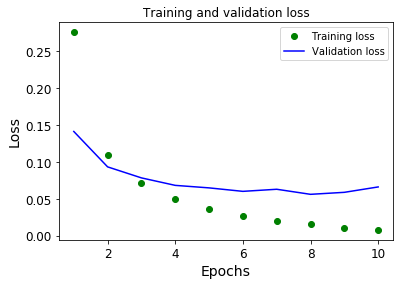

In [0]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

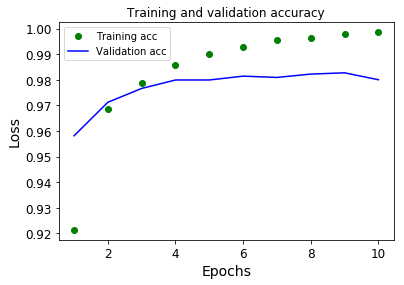

In [0]:
# Plotting the training and validation accuracy
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Create a confusion matrix to assess accuracy.

In [0]:
# Predicting the Test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

In [0]:
# Creating the Confusion Matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

[[ 972    1    1    0    1    0    2    1    1    1]
 [   2 1124    3    0    0    0    2    1    3    0]
 [   5    1  998    4    1    0    2   15    6    0]
 [   0    0    2  989    0    4    0    6    0    9]
 [   4    0    3    0  964    0    1    3    0    7]
 [   2    0    0    9    1  876    2    0    1    1]
 [   7    2    1    1    3    7  935    2    0    0]
 [   5    0    3    0    0    0    0 1017    0    3]
 [   9    1    3   10    4    5    1    4  928    9]
 [   3    2    0    3   11    1    0    4    0  985]]


In [0]:
# Visualizing weights and convolutions
def get_activations(model, model_inputs, print_shape_only=True, layer_name=None):
    import keras.backend as K
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(1.)
    else:
        list_inputs = [model_inputs, 1.]

    # Learning phase. 1 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 1.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

In [0]:
activations = get_activations(model, X_test)

----- activations -----
(10000, 784)
(10000, 10)


In [0]:
print(activations[0])

[[1.0245473  0.14888251 0.         ... 0.         0.3187959  0.55733323]
 [0.1265097  0.         1.005538   ... 0.         0.         0.        ]
 [0.         1.2314919  0.3135202  ... 0.         0.         0.        ]
 ...
 [0.78791666 0.         0.         ... 0.4846087  1.4207877  0.        ]
 [0.35620636 0.         0.42138952 ... 0.03311625 0.21738215 0.        ]
 [0.8332108  1.2875623  0.         ... 0.         0.         0.        ]]


### Section 4:  Conclusion

**Management problem: ** Regarding the management problem for this assignment. Suppose you are asked to develop a neural network model for digit classification. How would you go about training such a model? How would you judge the model's accuracy in digit classification with real data examples, such as customer or client handwritten digits on paper?

>**Summary Table of Models:**


>Number of Layers | Nodes Per Layer | Processing Time | Train Accuracy | Test Accuracy
>--- | ---
>1 | 10  | 6.62 s | 0.8154 | 0.8177
>1 | 50  | 10.8 s | 0.9514 | 0.9373
>1 | 100  | 15.8 s | 0.9775 | 0.9518
>1 | 784 | 12.6 s | 0.9986| 0.9803

**In Conclusion:**

After fitting a number of neural networks, processing time and performance was compared across experimental treatments.

The results showed:

*    The Keras neural network classification model with 1 hidden layer and 784 nodes per layer resulted in the most accurate predictions for handwritten digits.
*    Increasing the number nodes per layer increased accuracy.
*    As the number of nodes increased, the processing time was slower, with the exception of the Keras model.

The final recommendation is to implement the Keras neural network classificaiton model with 1 layers and 784 nodes per layer.  This model takes less time to process than other models with fewer nodes, it results in the most accurate predictions and is the most trustworthy.